In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from IPython.display import clear_output
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
import gc

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
train_data = pd.read_csv('metadata/UrbanSound8K.csv')

# add .png to the end of each filename
for i in range(len(train_data)):
    pre = 'images' + os.sep + 'fold' + str(train_data['fold'][i]) + os.sep
    train_data.at[i, 'slice_file_name'] = pre + train_data.at[i, 'slice_file_name'] + '.png'
    
train_data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,images\fold5\100032-3-0-0.wav.png,100032,0.0,0.317551,1,5,3,dog_bark
1,images\fold5\100263-2-0-117.wav.png,100263,58.5,62.500000,1,5,2,children_playing
2,images\fold5\100263-2-0-121.wav.png,100263,60.5,64.500000,1,5,2,children_playing
3,images\fold5\100263-2-0-126.wav.png,100263,63.0,67.000000,1,5,2,children_playing
4,images\fold5\100263-2-0-137.wav.png,100263,68.5,72.500000,1,5,2,children_playing


## Hyperparameters

In [4]:
# Define the target image size
height = 500
width = 500
channels = 3
target_size = (height, width)
target_shape = (height, width, channels)

# Define the class mode
class_mode = 'categorical'

# Define the number of folds
k = 10

# Define the batch size. It depends on your GPU
batch_size = 8

# Define the data generator for data augmentation
datagen = ImageDataGenerator(rescale=1./255,
                             fill_mode='nearest')

# Define the number of classes
num_classes = 10

## Model

In [5]:
# Define and compile the model

def create_model():
    tf.compat.v1.reset_default_graph()
    tf.keras.backend.clear_session()
    gc.collect()
    
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=target_shape),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

tf.keras.backend.clear_session()
gc.collect()
del model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 496, 496, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 248, 248, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 244, 244, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 122, 122, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 120, 120, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 128)      0

## Train the model with k-cross validation

In [6]:
# Define a dictionary to store the history of the model for each fold
fold2history = {}

tf.config.run_functions_eagerly(False)

# Start the k-fold cross validation
for fold in range(k):
    fold += 1
    
    # Define the model
    model = create_model()
    
    # Define the training and validation dataframes for this fold 
    train_dataframe = train_data[train_data['fold'] != fold]
    test_dataframe = train_data[train_data['fold'] == fold]
        
    histories = []
    
    for val in range(k):
        val += 1
        # Doesn't train on the test set
        if val == fold:
            continue
        
        train_df = train_dataframe[train_dataframe['fold'] != val]
        val_df = train_dataframe[train_dataframe['fold'] == val]
        
        # Define the directories for training and validation data
        train_datagen = datagen.flow_from_dataframe(
            dataframe=train_df,
            directory=None,
            x_col='slice_file_name',
            y_col='class',
            target_size=target_size,
            batch_size=batch_size,
            class_mode=class_mode)
    
        # Define the data generator for validation data
        val_datagen = datagen.flow_from_dataframe(
            dataframe=val_df,
            directory=None,
            x_col='slice_file_name',
            y_col='class',
            target_size=target_size,
            batch_size=batch_size,
            class_mode=class_mode)
        
        clear_output(wait=True)
        print(f'Testing with fold{fold}, Validating with fold{val}')
        
        # Train the model on the training data
        history = model.fit(train_datagen, validation_data=val_datagen, verbose=1)
        histories.append(history.history)
        
        del history, train_df, val_df, train_datagen, val_datagen
        
    
    test_datagen = datagen.flow_from_dataframe(
        dataframe=test_dataframe,
        directory=None,
        x_col='slice_file_name',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode)
    
    # Evaluate the model on the validation data
    loss, accuracy = model.evaluate(test_datagen)
    print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')
    
    # Save the history of the model for each fold
    fold2history[fold] = (histories, loss, accuracy)
    
    # Save the model for each fold
    model.save('models'+ os.sep +f'fold{fold}_model.h5')
    
    # Delete the model to free memory on GPU
    tf.compat.v1.reset_default_graph()
    tf.keras.backend.clear_session()
    gc.collect()
    del model, train_dataframe, test_dataframe, histories, test_datagen
    

Testing with fold10, Validating with fold9
885/885 [==============================] - 101s 114ms/step - loss: 0.0074 - accuracy: 0.9952 - val_loss: 0.0226 - val_accuracy: 0.9865
Found 837 validated image filenames belonging to 10 classes.
105/105 [==============================] - 8s 74ms/step - loss: 0.4027 - accuracy: 0.6476
Test loss: 0.4027, Test accuracy: 0.6476


In [35]:
history = []
test_loss = []
test_accuracy = []
for fold in fold2history.keys():
    for i in range(0,9):
        history.extend(fold2history[fold][0][i]['val_accuracy'])
    test_loss.append(fold2history[fold][1])
    test_accuracy.append(fold2history[fold][2])
    
print(f'Mean test loss: {np.mean(test_loss):.4f}, Mean test accuracy: {np.mean(test_accuracy):.4f}')

Mean test loss: 0.5755, Mean test accuracy: 0.6258


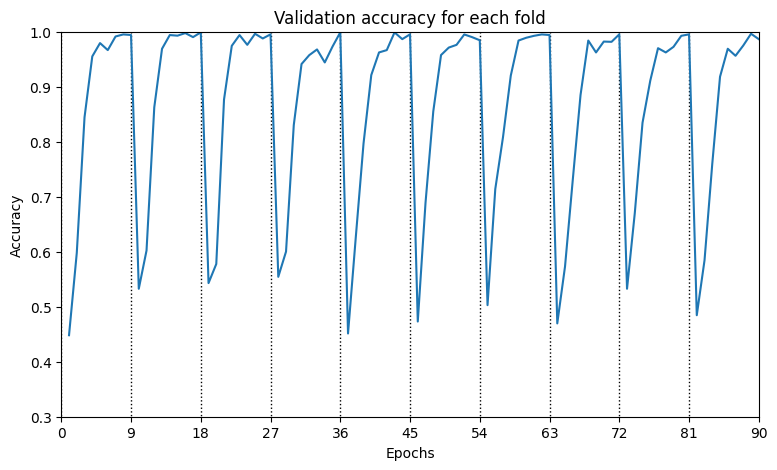

In [45]:
# validation accuracy for each fold
plt.figure(figsize=(9, 5))
plt.title('Validation accuracy for each fold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# set axis limits to show the plot clearly
plt.axis([1, len(history), 0.3, 1])

# draw dot lines for each fold
for i in range(0, 10):
    plt.plot([i*9, i*9], [0, 1], 'k:', linewidth=1)
    
plt.xticks(np.arange(0, len(history)+1, 9))
plt.plot(np.arange(1, len(history)+1), history, label='val_accuracy')

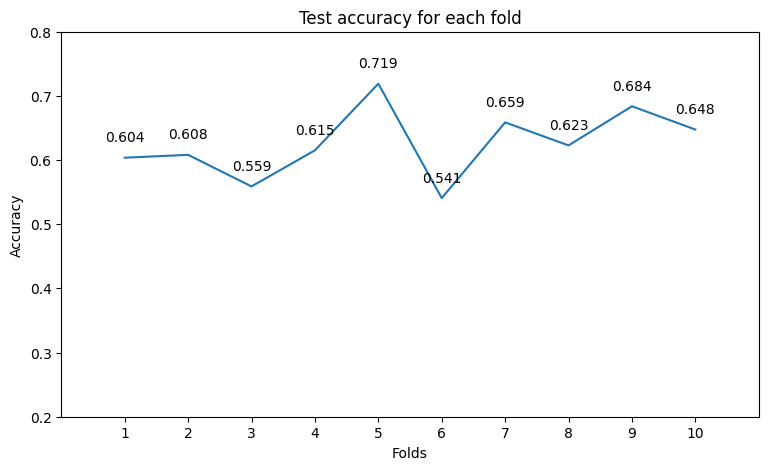

In [72]:
# test accuracy plot

plt.figure(figsize=(9, 5))
plt.title('Test accuracy for each fold')
plt.xlabel('Folds')
plt.ylabel('Accuracy')

# set axis limits to show the plot clearly
plt.axis([0, len(test_accuracy)+1, 0.2, 0.8])

for i, v in enumerate(test_accuracy):
    plt.text(i+1, v+0.025, "%.3f" %v, ha="center")
 
plt.xticks(np.arange(1, len(test_accuracy)+1, 1))   
plt.plot(np.arange(1, len(test_accuracy)+1), test_accuracy, label='test_accuracy')